In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# For deep learning
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing as keras_preprocessing

print(tf.__version__)


2.4.1


In [ ]:
# for when working in google colab
from google.colab import drive
drive.mount('/content/drive/')

In [18]:
# import data
# data_file = '/content/drive/MyDrive/6862_project/QCFilteredData.csv'
data_file = 'data/GOSHIP_Data/QCFilteredData.csv'
### ignore lat lon for now. Add later after zoning
### ignore month for now. One-hot encode later
data = pd.read_csv(data_file, header=0, usecols=[3,4,5,6,7,8,9,10,11], 
                   names=['lat','lon','pres','temp','sal','oxy','nitr','phsp','sili'])

In [19]:
# split data into training, validation, testing set
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)


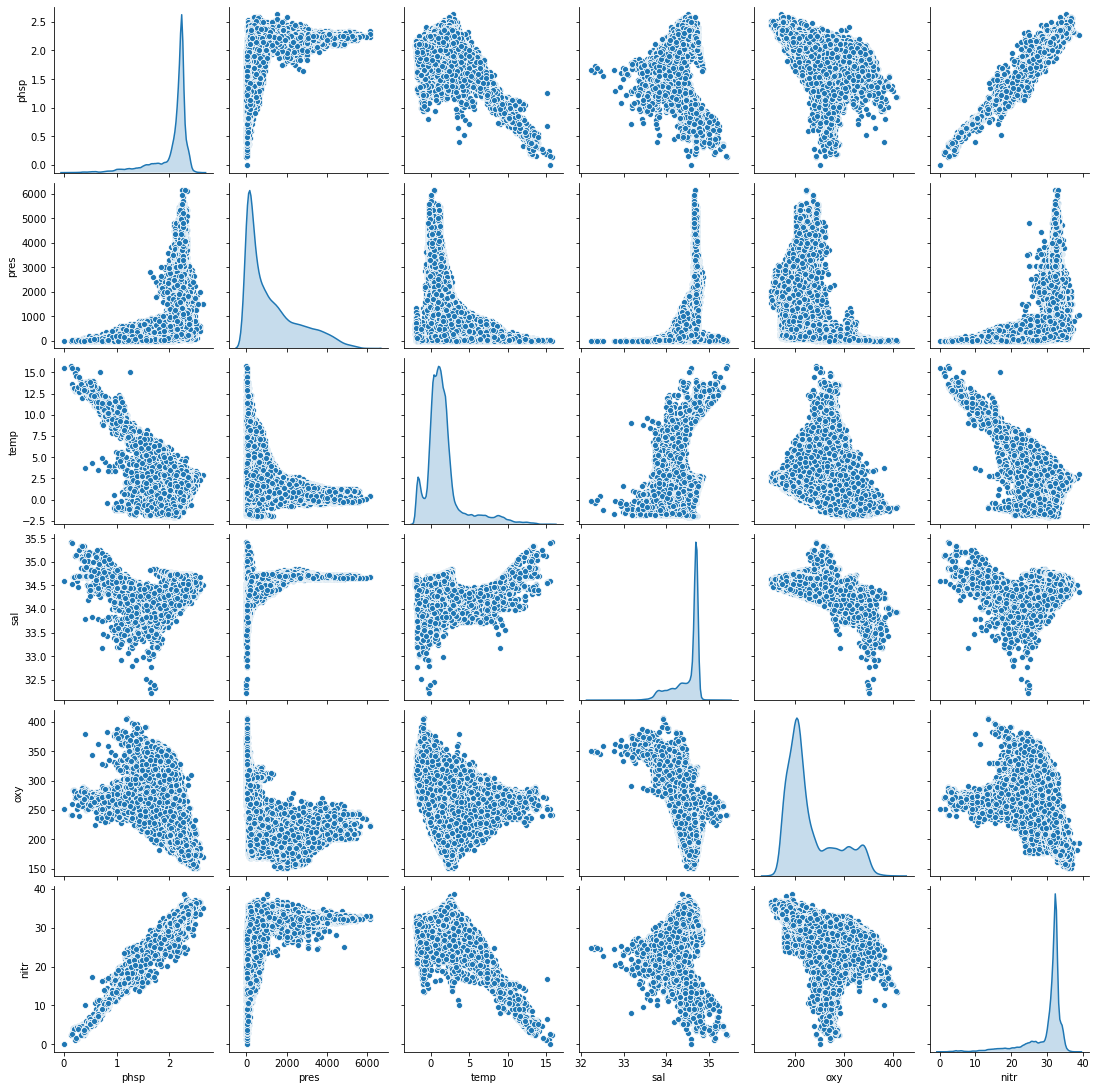

In [20]:
sns.pairplot(train_dataset[['phsp','pres','temp','sal','oxy','nitr']], diag_kind='kde')

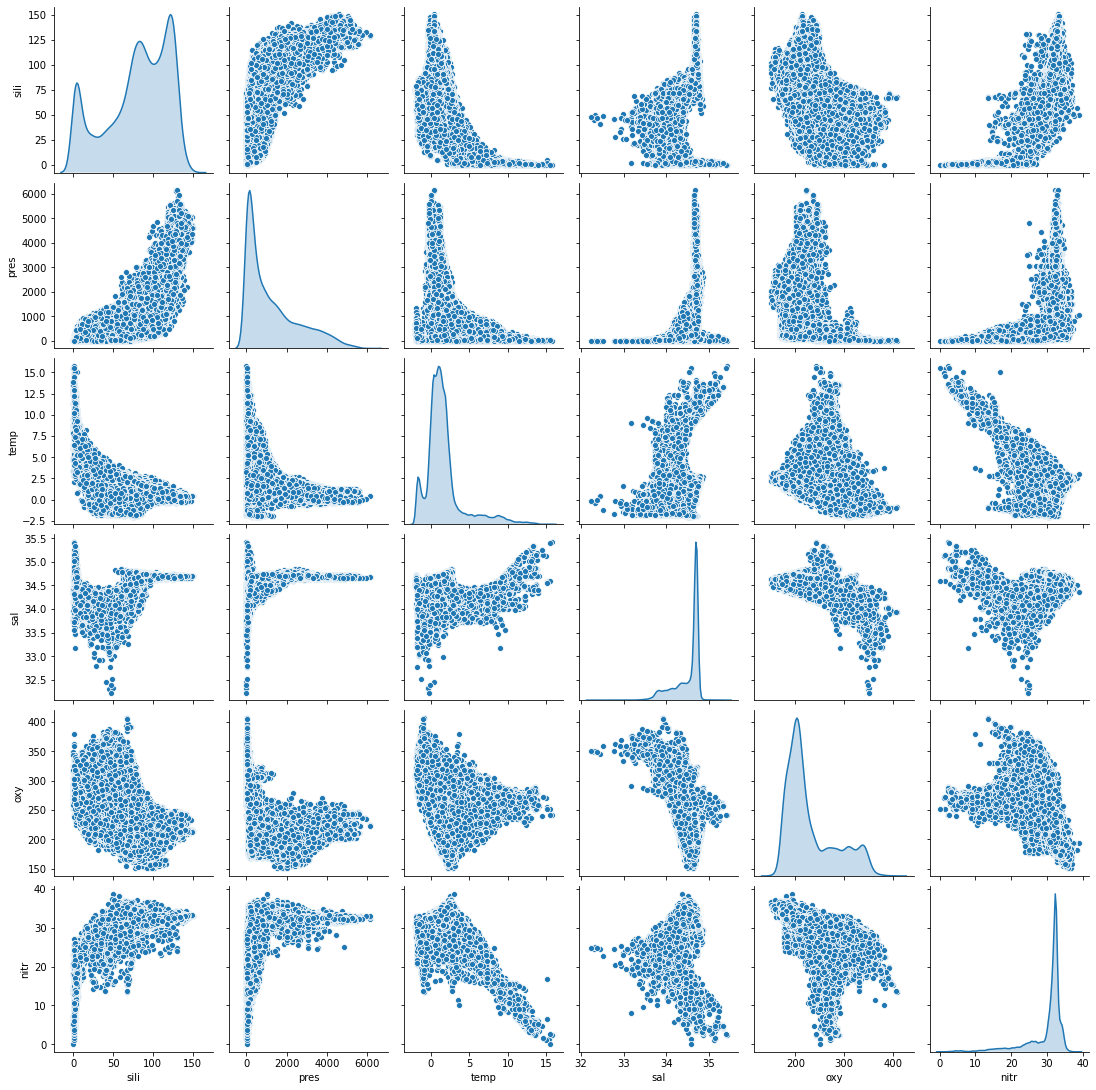

In [15]:
sns.pairplot(train_dataset[['sili','pres','temp','sal','oxy','nitr']], diag_kind='kde')

In [21]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lat,33930.0,-59.903027,7.542840,-75.7506,-66.505200,-61.83020,-53.9193,-45.0000
lon,33930.0,3.140392,118.452406,-179.2951,-106.750000,29.99980,115.0020,179.4228
pres,33930.0,1264.076808,1299.684429,0.7000,200.300000,798.80000,1999.6000,6155.6000
temp,33930.0,1.689565,2.498022,-2.0277,0.349725,1.18105,2.1000,15.7440
sal,33930.0,34.508702,0.300963,32.2280,34.368925,34.66990,34.7103,35.4240
oxy,33930.0,230.972748,50.322881,150.5000,195.100000,211.00000,261.2950,407.2000
nitr,33930.0,29.910701,5.162313,0.0000,29.900000,31.90000,32.5600,38.8100
phsp,33930.0,2.056368,0.347544,0.0000,2.040000,2.19000,2.2400,2.6300
sili,33930.0,80.245142,39.843012,0.0000,55.300000,86.83000,114.4000,150.7000


In [33]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_phsp = train_features.pop('phsp')
test_phsp = test_features.pop('phsp')

train_sili = train_features.pop('sili')
test_sili = test_features.pop('sili')

In [24]:
train_features.describe().transpose()[['mean', 'std']]


,mean,std
lat,-59.903027,7.542840
lon,3.140392,118.452406
pres,1264.076808,1299.684429
temp,1.689565,2.498022
sal,34.508702,0.300963
oxy,230.972748,50.322881
nitr,29.910701,5.162313


In [26]:
normalizer = keras_preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [27]:
# Single variable regression
nitr = np.array(train_features['nitr'])
nitr_normalizer = keras_preprocessing.Normalization(input_shape=[1,])
nitr_normalizer.adapt(nitr)

In [28]:
# build sequential model
nitr_model = tf.keras.Sequential([
    nitr_normalizer,
    layers.Dense(units=1)
])

nitr_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [116]:
nitr_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss='mean_squared_error')


In [117]:
%%time
history = nitr_model.fit(
    train_features['nitr'], train_phsp,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


Epoch 1/100
849/849 [==============================] - 1s 830us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 2/100
849/849 [==============================] - 1s 743us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 3/100
849/849 [==============================] - 1s 685us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/100
849/849 [==============================] - 1s 683us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 5/100
849/849 [==============================] - 1s 678us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 6/100
849/849 [==============================] - 1s 662us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 7/100
849/849 [==============================] - 1s 657us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/100
849/849 [==============================] - 1s 728us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 9/100
849/849 [==============================] - 1s 678us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/100
849/849 [==============================] - 1s 667us/step - l

Epoch 80/100
849/849 [==============================] - 1s 749us/step - loss: 0.0037 - val_loss: 0.0039
Epoch 81/100
849/849 [==============================] - 1s 657us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 82/100
849/849 [==============================] - 1s 656us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 83/100
849/849 [==============================] - 1s 644us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 84/100
849/849 [==============================] - 1s 657us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 85/100
849/849 [==============================] - 1s 706us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 86/100
849/849 [==============================] - 1s 685us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 87/100
849/849 [==============================] - 1s 692us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 88/100
849/849 [==============================] - 1s 657us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 89/100
849/849 [==============================] - 1s 650us

In [118]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,0.003890,0.003858,95
96,0.003889,0.003858,96
97,0.003889,0.003858,97
98,0.003889,0.003857,98
99,0.003889,0.003858,99


In [119]:
def plot_loss(history, ymin, ymax):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([ymin, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error [nitr]')
  plt.legend()
  plt.grid(True)


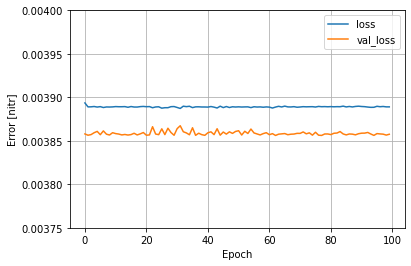

In [124]:
plot_loss(history, 0.00375, 0.004)


In [125]:
# collect the results for later use
test_results = {}

test_results['nitr_model'] = nitr_model.evaluate(
    test_features['nitr'],
    test_phsp, verbose=0)


In [126]:
x = tf.linspace(0.0, 40, 100)
y = nitr_model.predict(x)


In [127]:
def plot_nitr(x, y):
  plt.scatter(train_features['nitr'], train_phsp, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('nitr')
  plt.ylabel('phsp')
  plt.legend()


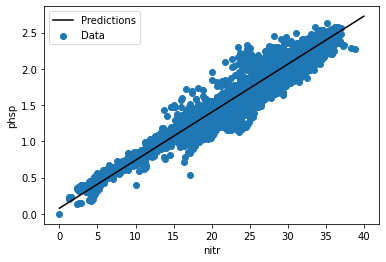

In [128]:
plot_nitr(x,y)


In [129]:
# multiple input regression
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')


In [130]:
%%time
history = linear_model.fit(
    train_features, train_phsp, 
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


Epoch 1/100
849/849 [==============================] - 1s 848us/step - loss: 4.0769 - val_loss: 1.8251
Epoch 2/100
849/849 [==============================] - 1s 673us/step - loss: 1.3916 - val_loss: 0.5421
Epoch 3/100
849/849 [==============================] - 1s 701us/step - loss: 0.3923 - val_loss: 0.1192
Epoch 4/100
849/849 [==============================] - 1s 686us/step - loss: 0.0838 - val_loss: 0.0285
Epoch 5/100
849/849 [==============================] - 1s 684us/step - loss: 0.0223 - val_loss: 0.0144
Epoch 6/100
849/849 [==============================] - 1s 667us/step - loss: 0.0121 - val_loss: 0.0086
Epoch 7/100
849/849 [==============================] - 1s 675us/step - loss: 0.0075 - val_loss: 0.0053
Epoch 8/100
849/849 [==============================] - 1s 667us/step - loss: 0.0046 - val_loss: 0.0038
Epoch 9/100
849/849 [==============================] - 1s 718us/step - loss: 0.0038 - val_loss: 0.0034
Epoch 10/100
849/849 [==============================] - 1s 659us/step - l

Epoch 80/100
849/849 [==============================] - 1s 670us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 81/100
849/849 [==============================] - 1s 658us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 82/100
849/849 [==============================] - 1s 662us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 83/100
849/849 [==============================] - 1s 664us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 84/100
849/849 [==============================] - 1s 665us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 85/100
849/849 [==============================] - 1s 718us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 86/100
849/849 [==============================] - 1s 659us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 87/100
849/849 [==============================] - 1s 667us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 88/100
849/849 [==============================] - 1s 664us/step - loss: 0.0035 - val_loss: 0.0034
Epoch 89/100
849/849 [==============================] - 1s 661us

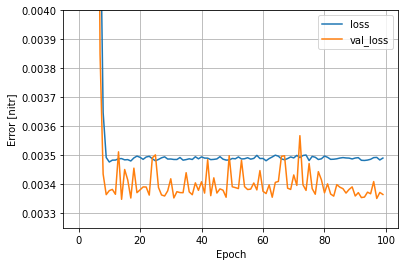

In [137]:
plot_loss(history, 0.00325,0.004)


In [138]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_phsp, verbose=0)


In [139]:
### DNN regression
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [140]:
sal = np.array(train_features['sal'])
sal_normalizer = keras_preprocessing.Normalization(input_shape=[1,])
sal_normalizer.adapt(sal)

In [141]:
# one variable
dnn_sal_model = build_and_compile_model(sal_normalizer)
dnn_sal_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [142]:
# train the model
# %%time
history = dnn_sal_model.fit(
    train_features['sal'], train_phsp,
    validation_split=0.2,
    verbose=1, epochs=100)


Epoch 1/100
849/849 [==============================] - 1s 984us/step - loss: 0.6698 - val_loss: 0.0877
Epoch 2/100
849/849 [==============================] - 1s 860us/step - loss: 0.0865 - val_loss: 0.0738
Epoch 3/100
849/849 [==============================] - 1s 842us/step - loss: 0.0803 - val_loss: 0.0748
Epoch 4/100
849/849 [==============================] - 1s 941us/step - loss: 0.0791 - val_loss: 0.0739
Epoch 5/100
849/849 [==============================] - 1s 798us/step - loss: 0.0820 - val_loss: 0.0727
Epoch 6/100
849/849 [==============================] - 1s 791us/step - loss: 0.0802 - val_loss: 0.0723
Epoch 7/100
849/849 [==============================] - 1s 808us/step - loss: 0.0760 - val_loss: 0.0713
Epoch 8/100
849/849 [==============================] - 1s 834us/step - loss: 0.0811 - val_loss: 0.0721
Epoch 9/100
849/849 [==============================] - 1s 789us/step - loss: 0.0801 - val_loss: 0.0758
Epoch 10/100
849/849 [==============================] - 1s 822us/step - l

Epoch 80/100
849/849 [==============================] - 1s 810us/step - loss: 0.0793 - val_loss: 0.0716
Epoch 81/100
849/849 [==============================] - 1s 854us/step - loss: 0.0780 - val_loss: 0.0713
Epoch 82/100
849/849 [==============================] - 1s 814us/step - loss: 0.0779 - val_loss: 0.0715
Epoch 83/100
849/849 [==============================] - 1s 798us/step - loss: 0.0784 - val_loss: 0.0711
Epoch 84/100
849/849 [==============================] - 1s 840us/step - loss: 0.0803 - val_loss: 0.0729
Epoch 85/100
849/849 [==============================] - 1s 842us/step - loss: 0.0812 - val_loss: 0.0716
Epoch 86/100
849/849 [==============================] - 1s 808us/step - loss: 0.0800 - val_loss: 0.0715
Epoch 87/100
849/849 [==============================] - 1s 798us/step - loss: 0.0761 - val_loss: 0.0715
Epoch 88/100
849/849 [==============================] - 1s 845us/step - loss: 0.0776 - val_loss: 0.0712
Epoch 89/100
849/849 [==============================] - 1s 833us

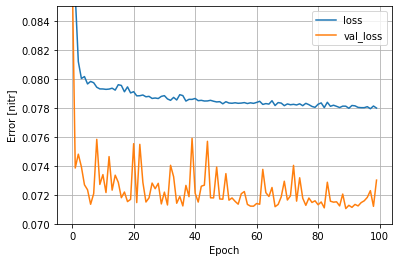

In [146]:
plot_loss(history, 0.07, 0.085)


In [147]:
def plot_sal(x, y):
  plt.scatter(train_features['sal'], train_phsp, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('sal')
  plt.ylabel('phsp')
  plt.legend()

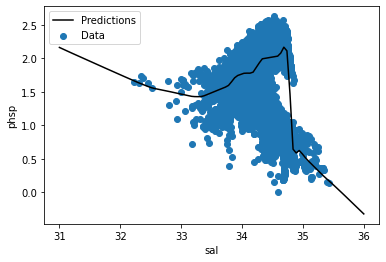

In [149]:
x = tf.linspace(31, 36, 100)
y = dnn_sal_model.predict(x)
plot_sal(x, y)


In [150]:
test_results['dnn_sal_model'] = dnn_sal_model.evaluate(
    test_features['sal'], test_phsp,
    verbose=0)


In [151]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense_24 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________


In [152]:
%%time
history = dnn_model.fit(
    train_features, train_phsp,
    validation_split=0.2,
    verbose=1, epochs=100)


Epoch 1/100
849/849 [==============================] - 1s 1ms/step - loss: 0.3029 - val_loss: 0.0066
Epoch 2/100
849/849 [==============================] - 1s 870us/step - loss: 0.0059 - val_loss: 0.0035
Epoch 3/100
849/849 [==============================] - 1s 901us/step - loss: 0.0041 - val_loss: 0.0029
Epoch 4/100
849/849 [==============================] - 1s 855us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/100
849/849 [==============================] - 1s 854us/step - loss: 0.0031 - val_loss: 0.0024
Epoch 6/100
849/849 [==============================] - 1s 849us/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/100
849/849 [==============================] - 1s 902us/step - loss: 0.0027 - val_loss: 0.0034
Epoch 8/100
849/849 [==============================] - 1s 850us/step - loss: 0.0026 - val_loss: 0.0022
Epoch 9/100
849/849 [==============================] - 1s 841us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 10/100
849/849 [==============================] - 1s 842us/step - los

Epoch 80/100
849/849 [==============================] - 1s 838us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 81/100
849/849 [==============================] - 1s 893us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 82/100
849/849 [==============================] - 1s 846us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 83/100
849/849 [==============================] - 1s 876us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 84/100
849/849 [==============================] - 1s 857us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 85/100
849/849 [==============================] - 1s 873us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 86/100
849/849 [==============================] - 1s 879us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 87/100
849/849 [==============================] - 1s 840us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 88/100
849/849 [==============================] - 1s 846us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 89/100
849/849 [==============================] - 1s 849us

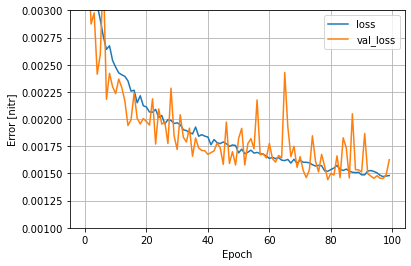

In [157]:
plot_loss(history, 0.001, 0.003)


In [158]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_phsp, verbose=0)


In [159]:
pd.DataFrame(test_results, index=['Mean squared error [phsp]']).T

,Mean squared error [phsp]
nitr_model,0.003778
linear_model,0.003323
dnn_sal_model,0.084778
dnn_model,0.001821


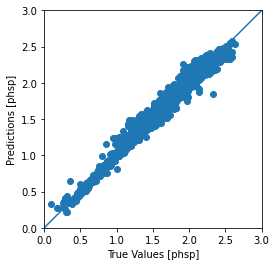

In [160]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_phsp, test_predictions)
plt.xlabel('True Values [phsp]')
plt.ylabel('Predictions [phsp]')
lims = [0, 3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


min_error:  -0.48430665016174324
max_error:  0.3347776699066163


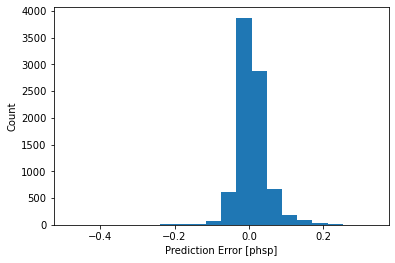

In [161]:
error = test_predictions - test_phsp
plt.hist(error, bins=20)
plt.xlabel('Prediction Error [phsp]')
_ = plt.ylabel('Count')
print("min_error: ", np.min(error))
print("max_error: ", np.max(error))